In [ ]:
#----------------------------------------------------------------------------------------------------------------#
# 摘要：此代码为随机森林地层岩性预测示例代码，使用荷兰北海F3探区的公开数据，以井点岩性数据为标签，多种时间域三维 #
# 地球物理数据（地震数据、地震属性、地震反演纵波阻抗、地质统计学反演自然伽马）为特征，训练随机森林分类模型实现井 #
# 间区域的地层岩性预测。                                                                                         #
#                                                                                                                #
# 作者：王光宇                                                                                                   #
# 时间：2022年6月11日                                                                                            #
# 备注：如果你在使用程序的过程中有任何问题，请将问题发送至邮箱wangguangyu721@163.com                             #
#----------------------------------------------------------------------------------------------------------------#

In [ ]:
# 查看井点岩性数据格式和井数据时深关系格式，为后续的样本制作做准备。

# 引入所需的函数库。
import pandas as pd
import os

# 输入文件路径。
path = 'Demo dataset/Lithology prediction'

# 输入井名称（以F02-1井为例，其他井数据格式与F02-1井相同）。
well = 'F02-1'

# 加载并查看井点岩性数据。
log_file = os.path.join(path, well+'_WellLogs.dat')
df_log = pd.read_csv(log_file, sep='\t')
print(f'{well}井岩性数据预览：\n', df_log)

# 加载井数据时深关系。
dt_file = os.path.join(path, well+'_D2TModel.dat')
df_dt = pd.read_csv(dt_file, sep='\t')
print(f'\n{well}井数据时深关系预览：\n', df_dt)

In [ ]:
# 制作样本集。

# 引入所需的函数库。
from preprocessing import *
from visualization import *
import sys

# 输入文件路径。
path = 'Demo dataset/Lithology prediction'

# 输入作为样本的井名称，以及井位置（以线道号表示[inline, crossline]）。
well_list = {'F02-1': [362, 336], 'F03-2': [722, 848], 'F03-4': [442, 1007], 'F06-1': [244, 387]}

# 输入作为样本特征的地球物理数据文件名，以及对应的特征名称。
feature_list = {'Absorption_Quality_Factor.sgy': 'Q', 
                'GR.sgy': 'GR', 
                'Instantaneous_Amplitude.sgy': 'Ins_amp', 
                'Instantaneous_Frequency.sgy': 'Ins_fre', 
                'Peakedness.sgy': 'Peakedness', 
                'P-wave_Impedance.sgy': 'Ip', 
                'RMS_Energy.sgy': 'RMS_energy', 
                'Seismic.sgy': 'Seis_amp', 
                'Spectral_Decomposition-24Hz.sgy': 'SD-24Hz', 
                'Spectral_Decomposition-44Hz.sgy': 'SD-44Hz', 
                'Spectral_Decomposition-64Hz.sgy': 'SD-64Hz'}

# 输入井点岩性数据文件中的岩性数据列名和深度数据列名。
log = 'Litholog__10_sand_15_silt_20_silty_shale_30_shale_' # 样本标签列名。
log_d = 'Depth(m)'

# 输入时深关系文件中深度和时间数据列名。
dt_d = 'MD(m)'
t = 'TWT( ms )'

# 输入地球物理数据时间范围（单位：ms）。
t1 = 408
t2 = 1136

# 对每一口井单独操作。
for well, loc in zip(well_list.keys(), well_list.values()):
    sys.stdout.write(f'正在处理{well}井...\n')
    # 将井点的岩性数据从深度域转换到时间域，并按照地震数据的采样率进行重采样，作为样本标签。
    # 加载数据。
    log_file = os.path.join(path, well+'_WellLogs.dat') # 井点岩性数据文件名。
    dt_file = os.path.join(path, well+'_D2TModel.dat') # 时深关系文件名。
    df_log = pd.read_csv(log_file, sep='\t') # 加载井点岩性数据。
    df_dt = pd.read_csv(dt_file, sep='\t') # 加载时深关系。
    
    # 删除异常值。
    abv = 1e30 # 定义异常值。
    rows = [x for x in range(len(df_log)) if df_log.loc[x, log] == abv] # 找出岩性数据为异常值的行。
    df_log.drop(index=rows, inplace=True) # 删除岩性数据为异常值的行。
    df_log.reset_index(drop=True, inplace=True) # 重置dataframe的索引（index）。

    # 深—时转换：根据井数据时深关系，将岩性数据从深度域转换到时间域。
    sys.stdout.write('\t岩性数据深-时转换：')
    df_log = time_log(df_dt=df_dt, df_log=df_log, log_depth_col=log_d, dt_depth_col=dt_d, time_col=t, log_col=log, nominal=True,
                      delete_nan=True) # time_log函数位于preprocessing函数库中。
    sys.stdout.write('完成。\n')
    
    # 重采样：将时间域的岩性数据按照地震数据的采样率（本示例数据为4ms）进行重采样。
    sys.stdout.write('\t岩性数据重采样：')
    df_log = resample_log(df_log=df_log, delta=4, depth_col=t, log_col=log, method='nearest', nominal=True, 
                          delete_nan=True) # resample_log函数位于preprocessing函数库中。
    sys.stdout.write('完成。\n')
    
    # 将岩性数据二分类，sand和silt统一分为砂岩（sand），标签为1；silty shale和shale统一分为泥岩（shale），标签为0。
    df_log.loc[df_log[log] < 20, log] = 1
    df_log.loc[df_log[log] >= 20, log] = 0
    
    # 截取在地球物理数据时间范围内的样本。
    df_log = df_log.loc[(df_log[t]>=t1)&(df_log[t]<=t2), :]
    df_log.reset_index(drop=True, inplace=True)
    
    # 更改岩性数据列名。
    df_log.rename(columns={t: 'TWT(ms)', log: 'LithoCode_0_shale_1_sand'}, inplace=True)
    
    # 逐一将三维地球物理数据的井旁道数据抽取出来，作为样本特征，与井点时间域岩性标签匹配，形成样本集。
    for feature, fname in zip(feature_list.keys(), feature_list.values()):
        sys.stdout.write(f'\t正在匹配样本特征{fname}：')
        df_log = cube2well(cube_file=os.path.join(path, feature), cube_name=fname, header_x=189, header_y=193, df=df_log, z_col='TWT(ms)', 
                           well_coord=loc, w_x=1, w_y=1, w_z=4, mute=True) # cube2well函数位于preprocessing函数库中。
        sys.stdout.write('完成。\n')
    
    # 删除位于目标层段外的样本（纵波阻抗Ip等于0表示该样本位于目标层段之外）。
    rows = [x for x in range(len(df_log)) if df_log.loc[x, 'Ip'] == 0]
    df_log.drop(index=rows, inplace=True)
    df_log.reset_index(drop=True, inplace=True)
    
    # 保存样本集。
    sys.stdout.write('\t保存样本集：')
    df_log.to_csv(os.path.join(path, well+'_Dataset.csv'), index=False)
    sys.stdout.write('完成。\n')
    
    # 预览样本集数据。
    print(f'\n{well}井样本集预览：\n', df_log)
        
    # 井点时间域岩性数据可视化，黄色代表砂岩，蓝色代表泥岩。
    plot_log(df_log=df_log[['TWT(ms)', 'LithoCode_0_shale_1_sand']], depth_name='TWT(ms)', log_name='LithoCode_0_shale_1_sand', 
             colors=['blue', 'gold'], categorical=True, ylabel=t, title=well) # plot_log函数位于visualization函数库中。

In [ ]:
# 样本特征优选。
from preprocessing import *
import os

# 定义随机数种子。
rdm = 42

# 初始化一个dataframe。
dataset = pd.DataFrame()

# 将每一口井的样本组合起来。
for well in well_list.keys():
    temp = pd.read_csv(os.path.join(path, well+'_Dataset.csv'))
    dataset = dataset.append(temp, ignore_index=True)

# 指明样本特征和标签。
X = dataset.drop(columns=['TWT(ms)', 'LithoCode_0_shale_1_sand'])
y = dataset[['LithoCode_0_shale_1_sand']]

# 自动优选样本特征。
X_new, y, selector = feature_selection(X, y, random_state=rdm, cv=5, scoring='balanced_accuracy', auto=True) # feature_selection算法位于preprocessing函数库中。

In [ ]:
# 选择F02-1、F03-2、F06-1井的样本为训练集。

# 输入井名称。
train_well = ['F02-1', 'F03-2', 'F06-1']

# 初始化训练集DataFrame。
train = pd.DataFrame()

# 加载F02-1、F03-2和F06-1井的样本。
for well in train_well:
    temp = pd.read_csv(os.path.join(path, well+'_Dataset.csv'))
    train = train.append(temp, ignore_index=True)

# 将时间和岩性数据单独取出来。
tv = train[['TWT(ms)', 'LithoCode_0_shale_1_sand']]

# 将样本特征数据取出来。
f = train.drop(columns=['TWT(ms)', 'LithoCode_0_shale_1_sand'])

# 优选样本特征。
fs = selector.transform(f)
fs = pd.DataFrame(data=fs, columns=selector.get_feature_names_out())

# 将时间和岩性数据与优选的样本特征重新组合起来，形成新的训练集。
train = pd.concat([tv, fs], axis=1)

# 预览训练集。
print('训练集（优选样本特征）预览：\n', train)

In [ ]:
# 对训练集各类样本数量进行平衡化处理。

# 指明样本特征和标签。
X = train.drop(columns=['TWT(ms)', 'LithoCode_0_shale_1_sand']) # 样本特征。
y = train[['LithoCode_0_shale_1_sand']] # 样本标签。

# SMOTE平衡化算法。
X_new, y_new = balance_class(X, y, random_state=rdm, smote_strategy='not majority', enn_strategy=None) # balance_class算法位于preprocessing函数库中。

In [ ]:
# 训练随机森林分类模型。

# 引入所需的函数库。
from model import *

# 定义模型名称。
name = 'RFC_litho_pred.model'

# 训练。
rfc = rf_train(X=X_new, y=y_new, estimator='RFC', n_tree=300, max_feature='auto', model_name=os.path.join(path, name), random_state=rdm) # rf_train位于model函数库中。

Checking SEG-Y file info...Clear
Customized prediction area:
Inline: [100-750]
Xline: [1006-1008]
Time: [408-1136]
Predicting...[Line3, File8]100.00%
Checking SEG-Y file info...Clear
Customized prediction area:
Inline: [100-750]
Xline: [1006-1008]
Time: [408-1136]
Predicting...[Line3, File8]100.00%
岩性预测准确率: 75.38%
正在保存预测结果...完成


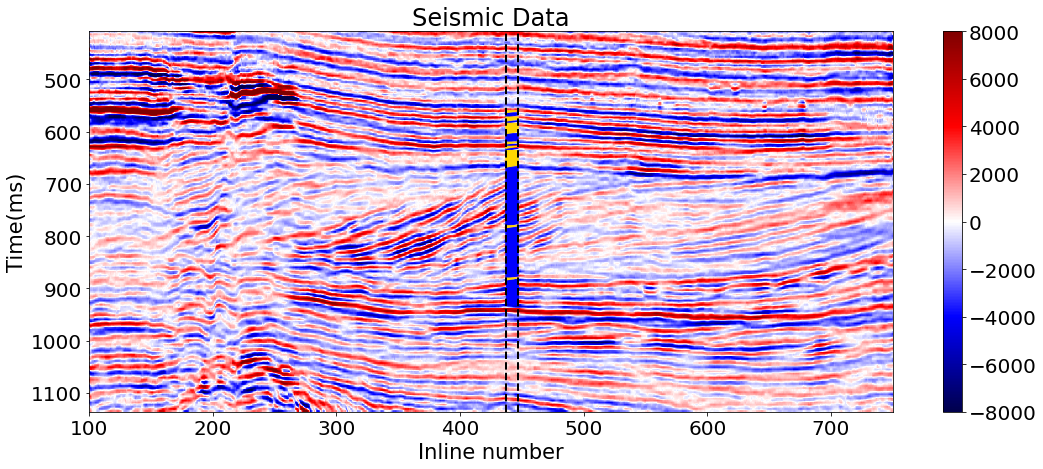

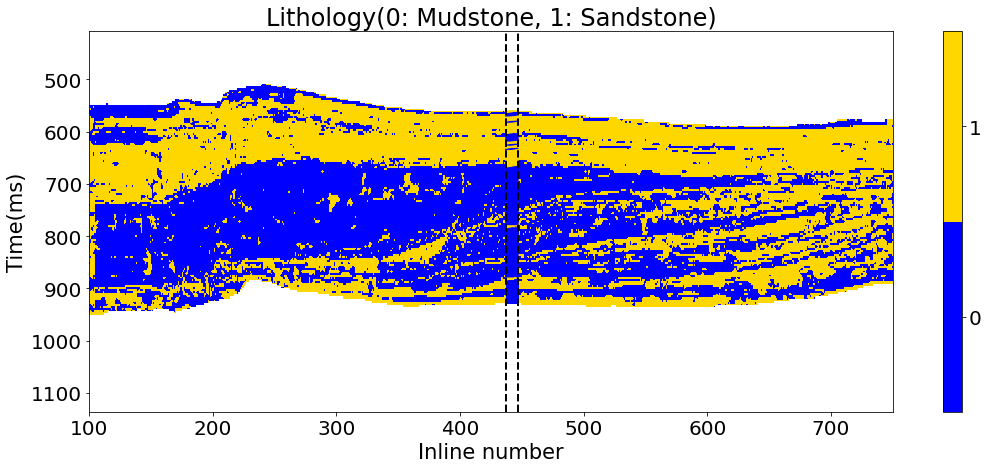

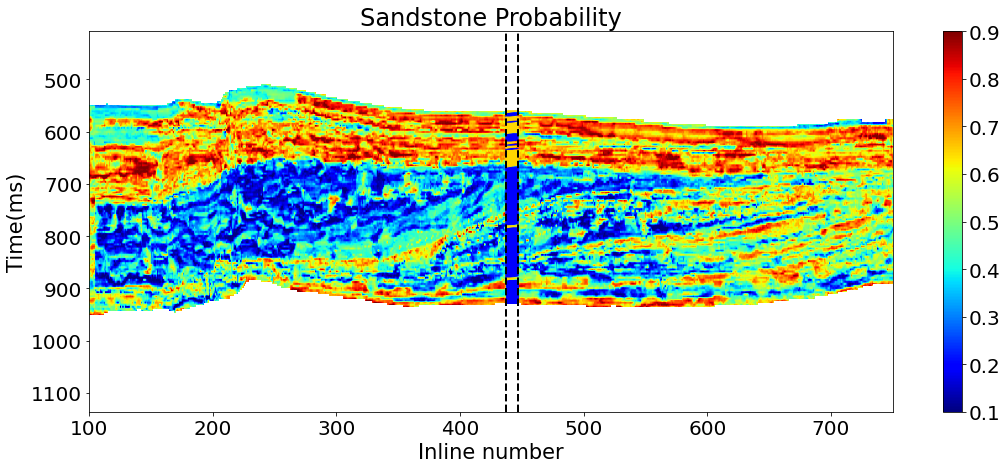

In [6]:
# 使用随机森林分类模型预测岩性。

# 引入所需函数。
from sklearn.metrics import balanced_accuracy_score
from matplotlib.colors import LinearSegmentedColormap

# 选择样本特征文件（必须按照训练样本集的特征顺序输入）。
input_file = ['GR.sgy', 'Instantaneous_Amplitude.sgy', 'Instantaneous_Frequency.sgy', 'P-wave_Impedance.sgy', 
              'RMS_Energy.sgy', 'Spectral_Decomposition-24Hz.sgy', 'Spectral_Decomposition-44Hz.sgy', 'Spectral_Decomposition-64Hz.sgy']
for i in range(len(input_file)):
    input_file[i] = os.path.join(path, input_file[i])

# 选择地震数据文件。
seis_file = 'Seismic.sgy'

# 选择预测结果显示范围控制文件（用该文件数据将目标范围之外的预测结果都置为无效值）。
r_file = 'P-wave_Impedance.sgy'

# 选择F03-4井的岩性数据作为测试集。
w_file = 'F03-4_Dataset.csv'

# 设置预测区域。
xr = [1006, 1008] # cross-line方向限制为1006号线~1008号线，inline方向不限。
w_loc = 442 # 井所在inline号。

# 加载地震数据。
with segyio.open(os.path.join(path, seis_file)) as f:
    il = f.ilines
    xl = f.xlines
    t = f.samples
    xl_ind1, xl_ind2 = np.squeeze(np.argwhere(xl == xr[0])), np.squeeze(np.argwhere(xl == xr[1]))
    seis = segyio.tools.cube(f)
    seis = seis[:, xl_ind1:xl_ind2+1, :]
f.close()

# 加载显示范围控制数据。
with segyio.open(os.path.join(path, r_file)) as f:
    r = segyio.tools.cube(f)
    r = r[:, xl_ind1:xl_ind2+1, :]
f.close()

# 加载测试集数据。
w = pd.read_csv(os.path.join(path, w_file), usecols=['TWT(ms)', 'LithoCode_0_shale_1_sand'])
w_t = w['TWT(ms)'].values
w_v = w['LithoCode_0_shale_1_sand'].values
w_ind = np.squeeze(np.argwhere(il == w_loc))

# 预测岩性。
litho = rf_predict(estimator=rfc, sgy_filelist=input_file, mode='slice', xline_range=xr, proba=False) # 预测岩性类别。
litho_p = rf_predict(estimator=rfc, sgy_filelist=input_file, mode='slice', xline_range=xr, proba=True) # 预测岩性概率。
litho_p = litho_p[:, :, :, 1] # 砂岩概率。
litho[r == 0] = np.nan # 目标范围之外的预测结果置为无效值。
litho_p[r == 0] = np.nan # 目标范围之外的预测结果置为无效值。

# 用F03-4井验证集数据计算岩性预测准确率。
ind_z1, ind_z2 = np.squeeze(np.argwhere(t == w_t[0])), np.squeeze(np.argwhere(t == w_t[-1]))
score = balanced_accuracy_score(w_v, litho[w_ind, 1, ind_z1:ind_z2+1])
print('岩性预测准确率: %.2f%%' % (score*100))

# 保存预测结果。
sys.stdout.write('正在保存预测结果...')
np.save(os.path.join(path, 'pred_lithoclass.npy'), litho)
np.save(os.path.join(path, 'pred_sandproba.npy'), litho_p)
sys.stdout.write('完成\n')

# 预览过F03-4井测线岩性预测结果。
# 定制色标（蓝色表示泥岩，黄色表示砂岩）。
color = ['blue', 'gold']
cm = LinearSegmentedColormap.from_list('custom', color, len(color))
# 地震数据可视化。
extent = [np.amin(il), np.amax(il), np.amax(t), np.amin(t)]
plt.figure(figsize=(18, 7))
plt.title('Seismic Data', fontsize=24)
plt.xlabel('Inline number', fontsize=21)
plt.ylabel('Time(ms)', fontsize=21)
plt.tick_params(labelsize=20)
plt.imshow(seis[:, 1, :].T, cmap='seismic', aspect='auto', extent=extent, vmin=-8000, vmax=8000)
cbar = plt.colorbar(orientation='vertical')
cbar.ax.tick_params(labelsize=20)
classlabel = list(dict(sorted(Counter(w_v).items())).keys())
for i in range(len(classlabel)):
    plt.fill_betweenx(w_t, w_loc-5, w_loc+5, where=(w_v == classlabel[i]), color=color[i], interpolate=True)
plt.axvline(x=w_loc-5, ls='--', c='k', lw=2)
plt.axvline(x=w_loc+5, ls='--', c='k', lw=2)
# 岩性类别预测结果可视化。
plt.figure(figsize=(18, 7))
plt.title('Lithology(0: Mudstone, 1: Sandstone)', fontsize=24)
plt.xlabel('Inline number', fontsize=21)
plt.ylabel('Time(ms)', fontsize=21)
plt.tick_params(labelsize=20)
plt.imshow(litho[:, 1, :].T, cmap=plt.cm.get_cmap(cm), aspect='auto', extent=extent)
tick_min = (max(classlabel) - min(classlabel)) / (2 * len(classlabel)) + min(classlabel)
tick_max = max(classlabel) - (max(classlabel) - min(classlabel)) / (2 * len(classlabel))
tick_step = (max(classlabel) - min(classlabel)) / len(classlabel)
ticks = np.arange(start=tick_min, stop=tick_max + tick_step, step=tick_step)
cbar = plt.colorbar(ticks=ticks, orientation='vertical')
cbar.ax.set_yticklabels(classlabel)
cbar.ax.tick_params(labelsize=20)
for i in range(len(classlabel)):
    plt.fill_betweenx(w_t, w_loc-5, w_loc+5, where=(w_v == classlabel[i]), color=color[i], interpolate=True)
plt.axvline(x=w_loc-5, ls='--', c='k', lw=2)
plt.axvline(x=w_loc+5, ls='--', c='k', lw=2)
# 砂岩概率预测结果可视化。
plt.figure(figsize=(18, 7))
plt.title('Sandstone Probability', fontsize=24)
plt.xlabel('Inline number', fontsize=21)
plt.ylabel('Time(ms)', fontsize=21)
plt.tick_params(labelsize=20)
plt.imshow(litho_p[:, 1, :].T, cmap='jet', aspect='auto', extent=extent, vmin=0.1, vmax=0.9)
cbar = plt.colorbar(orientation='vertical')
cbar.ax.tick_params(labelsize=20)
for i in range(len(classlabel)):
    plt.fill_betweenx(w_t, w_loc-5, w_loc+5, where=(w_v == classlabel[i]), color=color[i], interpolate=True)
plt.axvline(x=w_loc-5, ls='--', c='k', lw=2)
plt.axvline(x=w_loc+5, ls='--', c='k', lw=2)
plt.show()